In [72]:
import pandas as pd
import matplotlib.pyplot as plt

### Resumo

**Analistas de Dados**
<br> Seu trabalho vai ser entender o perfil de fraude

*júnior*
- Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!
- Como estão esses nossos KPIs atualmente?
- Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer
- (DONE) Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc
- Agora entenda o perfil do fraudador. Veja cada feature em relação aos fraudadores x não fraudadores. Use e abuse de correlações, testes de hipótese, etc
- <s>Faça um PowerBI ou Looker com os principais KPIs e gráficos que geram insights nesse tema</s>

*pleno*
- Use alguns algoritmos para melhor entendimento do perfil de fraude, como regressão logística ou algum outro que achar válido

*sênior*
- Construa “regras duras” para evitarmos fraude sem o uso de machine learning. Aqui são regras mesmo, por exemplo, se valor acima de X então barramos uma transação
- Discuta os prós e contras dessa sua estratégia
- Simule perdas e ganhos da estratégia
- Desenhe um teste AB para testarmos sua estratégia

**Cientistas de Dados**

*júnior*
- Façam uma EDA - Análise exploratória de dados. Podem se basear nas perguntas do analista para isso
- Desenvolva um modelo para predizer a variável Fraude (1-Sim, 0-Não). Quais técnicas testou? Qual selecionou como melhor abordagem? Explique!
- Compare o desempenho do seu algoritmo com o desempenho de um modelo anterior, cujo resultado é encontrado na coluna Score_fraude_modelo do dataset. Quais métricas usou e qual sua conclusão?
- Queremos encontrar o ponto de threshold ideal para o modelo já treinado apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o mais alto). Defina o ponto de corte que maximize os lucros da empresa, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

*pleno*
- Como você pode garantir que o desempenho do modelo no laboratório vai ser um proxy para o desempenho do modelo em produção?
- Supondo que o desempenho produtivo seja muito diferente do esperado, quais você acha que são as causas mais prováveis?
- Se o modelo precisar responder online, no menor tempo possível, o que isso mudaria no desenvolvimento do seu modelo?

<s>*sênior - projeto de alto impacto - ML Engineers*</s>

<s>Para aqueles que estão buscando vagas mais sênior ou realmente um projeto que destaque MUITO você. Minha dica é fazer isso se você já tiver estudado machine learning muito bem e já possa partir para conceitos de deploy 👇</s>
- <s>Use ferramentas como o MLFlow para testes</s>
- <s>Simule um deploy do modelo. Use Docker, Kuberneters, AWS, etc. Tudo que achar necessário para fazer o deploy</s>
- <s>Pense no monitoramento do modelo</s>

***Notas importante***

- Pra fins desse case os dados são anonimizados propositadamente. Para resolvê-lo, vocês vão precisar fazer algumas suposições. Justifique toda suposição que fizer
- Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento.

***Dados***

- **score_1** a **score_10**: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre
- **País**: pais de compra
- **Produto:** produto que está sendo comprado no e-commerce
- **Categoria_produto**: categoria a qual esse produto se encaixa
- **Entrega_doc_1** a **entrega_doc_3**: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou
- **Score_fraude_modelo**: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude
- **Fraude**: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

### **Cleaning** and **Modeling**

In [85]:
df = pd.read_csv('../../data/09. TCC/fraude/dados - dados.csv')
cols = list(df.columns)
cols.sort()
df = df[cols].copy()

df['datahora_compra'] = pd.to_datetime(df['data_compra'])
df['data_compra'] = df['datahora_compra'].dt.date
df['entrega_doc_2'] = df['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)
df['entrega_doc_3'] = df['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)

## corrigindo produtos com duas ou mais categorias, sua categoria oficial é a que mais aparece
df_qtde_categorias_produto = df.groupby('produto')['categoria_produto'].nunique().reset_index(name='qtde_categ')
df_qtde_categorias_produto = df_qtde_categorias_produto[df_qtde_categorias_produto['qtde_categ'] > 1]
for produto in df_qtde_categorias_produto['produto'].unique(): 
    df_qtde_categorias_produto = df[df['produto'] == produto].copy()

    oficial_categ = df_qtde_categorias_produto['categoria_produto'].value_counts().sort_values().index[-1]
    produto_indexes = df_qtde_categorias_produto.index
    df.loc[produto_indexes, 'categoria_produto'] = oficial_categ

## nivelando categoria de produtos
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos categorias para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de categorias com niveis altos em média acontecem com mais frequencia que niveis baixos.
# semelhante a pareto:
#    A: 1°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
df['categ_nivel'] = None

df_categ_freqs = df['categoria_produto'].value_counts().reset_index(name='frequencia')
df_categ_freqs['proporcao_frequencia_acumulada'] = df_categ_freqs['frequencia'].cumsum()/df_categ_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    categs = df_categ_freqs[(df_categ_freqs['proporcao_frequencia_acumulada'] > lower) & (df_categ_freqs['proporcao_frequencia_acumulada'] <= upper)]['categoria_produto']

    df.loc[df['categoria_produto'].isin(categs), 'categ_nivel'] = nivel
df = df.drop('categoria_produto', axis=1)

## nivelando produtos (só para produtos que tem mais que uma compra, caso contrario produto terá nivel E)
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos produtos para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de produtos com niveis altos em média acontecem com mais frequencia que niveis baixos.]
# semelhante a pareto: **(só para produtos que tem mais que uma compra)**
#    A: 1°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
df['prod_nivel'] = None

df_prod_freqs = df['produto'].value_counts().reset_index(name='frequencia')
df_prod_freqs = df_prod_freqs[df_prod_freqs['frequencia'] > 1].copy()
df_prod_freqs['proporcao_frequencia_acumulada'] = df_prod_freqs['frequencia'].cumsum()/df_prod_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    prods = df_prod_freqs[(df_prod_freqs['proporcao_frequencia_acumulada'] > lower) & (df_prod_freqs['proporcao_frequencia_acumulada'] <= upper)]['produto']

    df.loc[df['produto'].isin(prods), 'prod_nivel'] = nivel
df['prod_nivel'] = df['prod_nivel'].fillna('E')
df = df.drop('produto', axis=1)

# df['dia_compra'] = df['datahora_compra'].dt.day    ## não existe dados suficientes (por exemplo, dia 7 de 2010 até 2025) para essa feature ser importante
# df['mes_compra'] = df['datahora_compra'].dt.month  ## não existe dados suficientes (por exemplo, mês 4 de 2010 até 2025) para essa feature ser importante
# df['ano_compra'] = df['datahora_compra'].dt.year   ## não existe dados suficientes (por exemplo, 2010 até 2025) para essa feature ser importante
df['dia_semana_compra'] = df['datahora_compra'].dt.day_name()
df['periodo_dia_compra'] = df['datahora_compra'].dt.hour.apply(lambda x: 'Dawn' if x >= 0 and x < 6 else 'Morning' if x >= 6 and x < 12 else 'Afternoon' if x >= 12 and x < 18 else 'Night' if x >= 18 and x <= 23 else None)

df['pais'] = df['pais'].apply(lambda x: 'Others' if x not in ['BR','AR','UY','US'] else x) # ['BR','AR','UY','US'] são os top 4 paises com mais compras

# df = df.dropna()
# df = df.dropna(subset='pais') ## linhas com paises nulos correspondem a menos que 1% do dadaset

df = df.sort_values(by='data_compra')
df

,data_compra,entrega_doc_1,entrega_doc_2,entrega_doc_3,fraude,pais,score_1,score_10,score_2,score_3,...,score_7,score_8,score_9,score_fraude_modelo,valor_compra,datahora_compra,categ_nivel,prod_nivel,dia_semana_compra,periodo_dia_compra
92564,2020-03-08,0,0,0,0,BR,4,403.0,0.7776,35948.29,...,3,0.714921,404.0,79,33.12,2020-03-08 08:12:53,D,E,Sunday,Morning
72049,2020-03-08,1,0,0,0,BR,1,4.0,1.0000,21250.08,...,8,0.852102,434.0,87,16.16,2020-03-08 18:22:40,B,E,Sunday,Night
50901,2020-03-08,1,1,1,0,BR,4,206.0,0.8337,217309.00,...,28,0.737876,1904.0,49,33.88,2020-03-08 08:09:34,A,B,Sunday,Morning
88250,2020-03-08,1,0,1,0,BR,4,827.0,0.7039,260.60,...,13,0.782663,4196.0,67,12.20,2020-03-08 21:26:06,A,E,Sunday,Night
64370,2020-03-08,1,0,1,0,BR,4,191.0,0.6611,2790.40,...,9,0.577179,5850.0,10,3.12,2020-03-08 16:32:39,D,E,Sunday,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131711,2020-04-21,0,0,0,0,BR,4,0.0,0.8364,6097.81,...,0,0.476901,0.0,92,16.58,2020-04-21 16:22:54,B,E,Tuesday,Afternoon
60878,2020-04-21,0,0,0,0,BR,4,302.0,0.8029,773473.45,...,22,0.265030,304.0,57,28.91,2020-04-21 19:34:50,A,E,Tuesday,Night
143900,2020-04-21,1,0,1,0,BR,4,201.0,0.8337,39367.56,...,2,0.519621,4435.0,12,76.99,2020-04-21 11:23:47,B,E,Tuesday,Morning
22365,2020-04-21,1,0,1,0,BR,4,767.0,0.5450,9166.77,...,5,0.059025,4451.0,60,27.00,2020-04-21 10:04:35,A,E,Tuesday,Morning


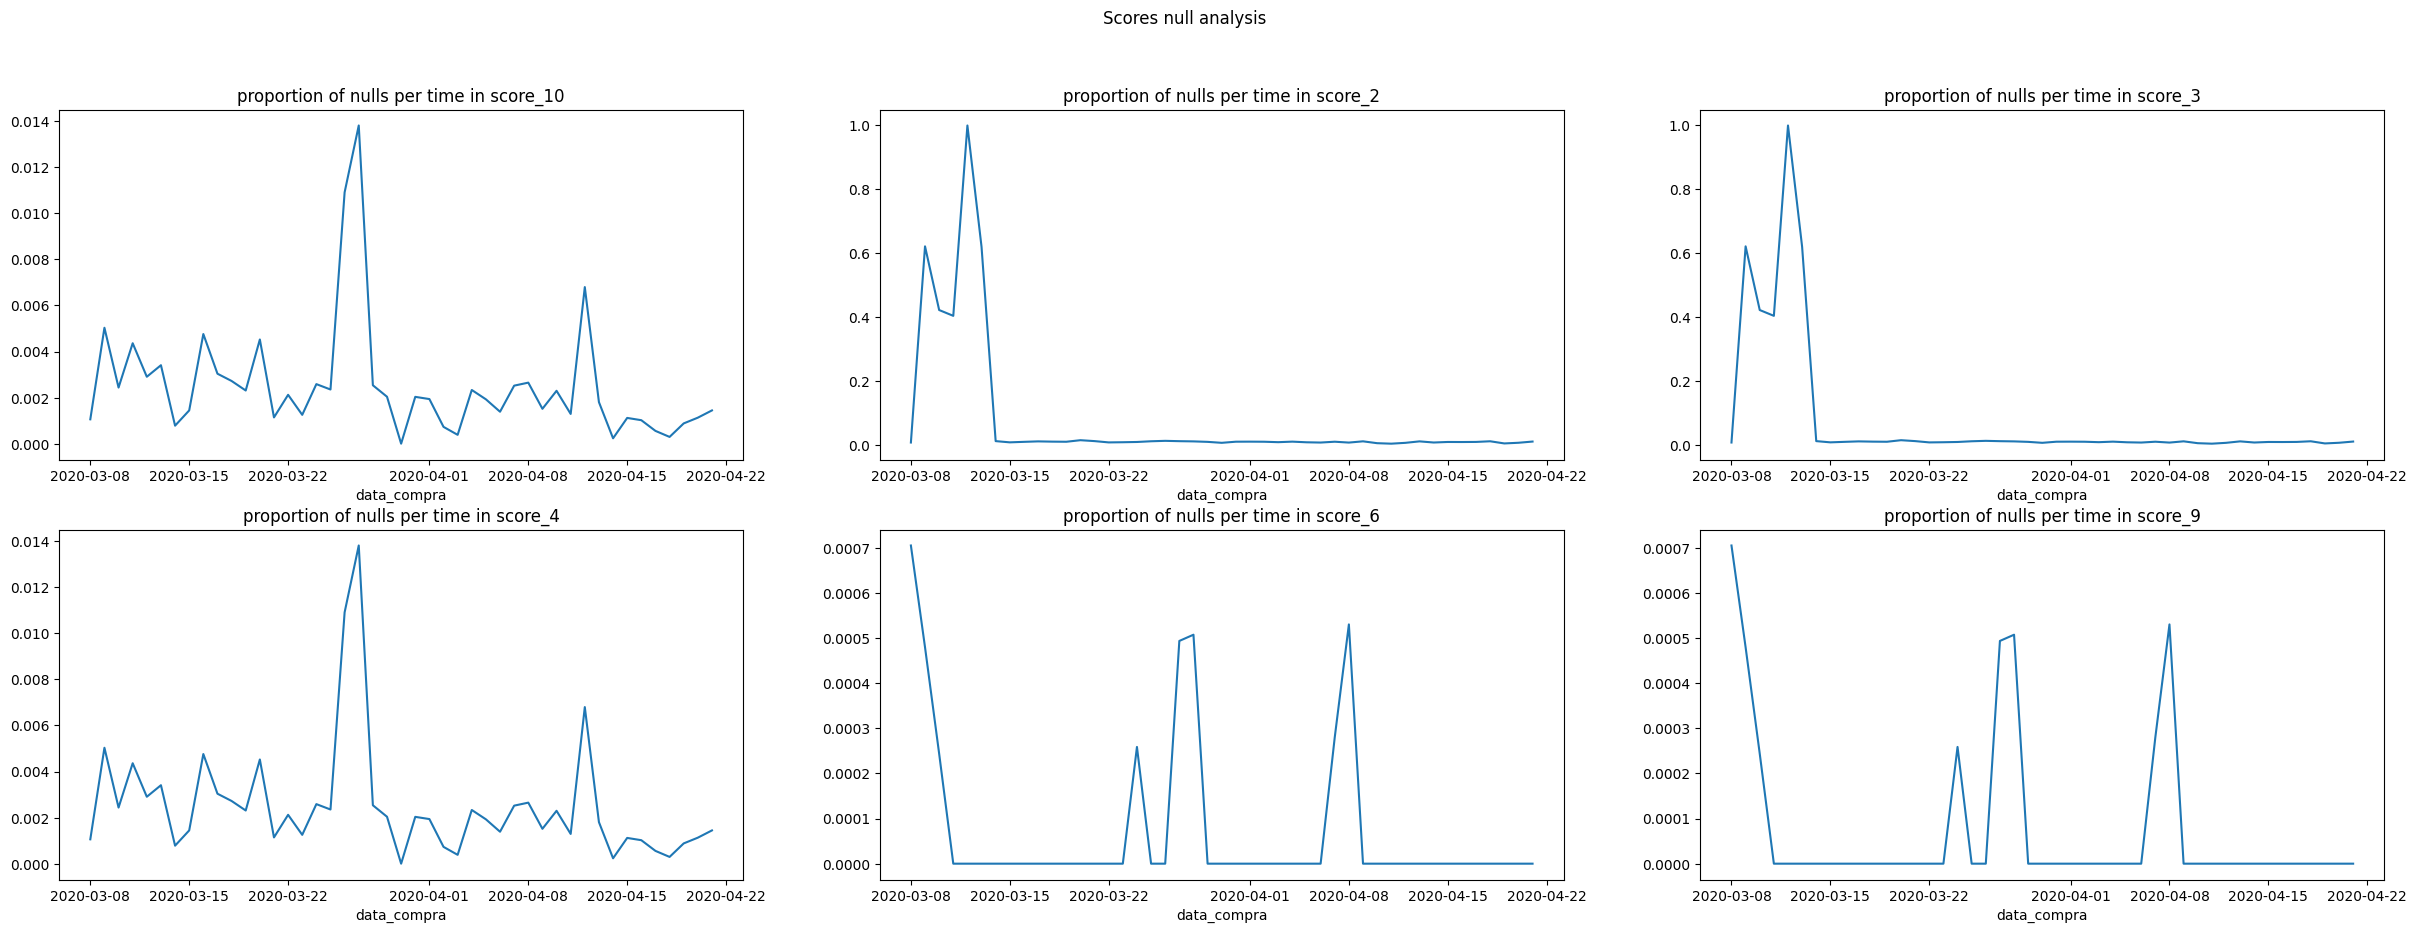

score nulls:


score_10      365
score_2     12984
score_3     12984
score_4       365
score_6        11
score_9        11
dtype: int64

score_10    365
score_4     365
dtype: int64

score_2    12984
score_3    12984
dtype: int64

score_6    11
score_9    11
dtype: int64

In [86]:

fig, ax = plt.subplots(2, 3, figsize=(30, 10))

score_with_null_cols = [col for col in df.columns if 'score' in col and 'modelo' not in col and df[col].isna().sum() > 0]
for i, col in enumerate(score_with_null_cols):
    x_pos = i//3
    y_pos = i%3

    df.groupby('data_compra')[col].apply(lambda x: len([x_i for x_i in x if str(x_i) == 'nan'])/len(x) ).plot.line(ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(f'proportion of nulls per time in {col}')

plt.suptitle(f'Scores null analysis')
plt.show()

print('score nulls:')
display(df[score_with_null_cols].isna().sum())
display(df[df['score_10'].isna()][['score_10','score_4']].isna().sum())
display(df[df['score_2'].isna()][['score_2','score_3']].isna().sum())
display(df[df['score_6'].isna()][['score_6','score_9']].isna().sum())

### **EDA** ~ analise univaridada e bivariada

In [135]:

print(df.shape)
print(f"data date range: {df['datahora_compra'].min()} to {df['datahora_compra'].max()} ~ {(df['datahora_compra'].max()-df['datahora_compra'].min())} of data")
print('target col: <fraude>')
print('leak for target col: <score_fraude_modelo>')
print('* no rows with nulls was deleted')
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(150000, 23)
data date range: 2020-03-08 00:02:15 to 2020-04-21 23:59:56 ~ 44 days 23:57:41 of data
target col: <fraude>
leak for target col: <score_fraude_modelo>
* no rows with nulls was deleted


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
data_compra,object,0,0.000000,45,"[2020-03-08, 2020-03-09, 2020-03-10]"
entrega_doc_1,int64,0,0.000000,2,"[0, 1]"
entrega_doc_2,int64,0,0.000000,2,"[0, 1]"
entrega_doc_3,int64,0,0.000000,2,"[0, 1]"
fraude,int64,0,0.000000,2,"[0, 1]"
pais,object,0,0.000000,5,"[BR, AR, Others]"
score_1,int64,0,0.000000,4,"[4, 1, 2]"
score_10,float64,365,0.002433,1793,"[403.0, 4.0, 206.0]"
score_2,float64,12984,0.086560,7672,"[0.7776, 1.0, 0.8337]"
score_3,float64,12984,0.086560,135090,"[35948.29, 21250.08, 217309.0]"


#### **Univariate** analisys

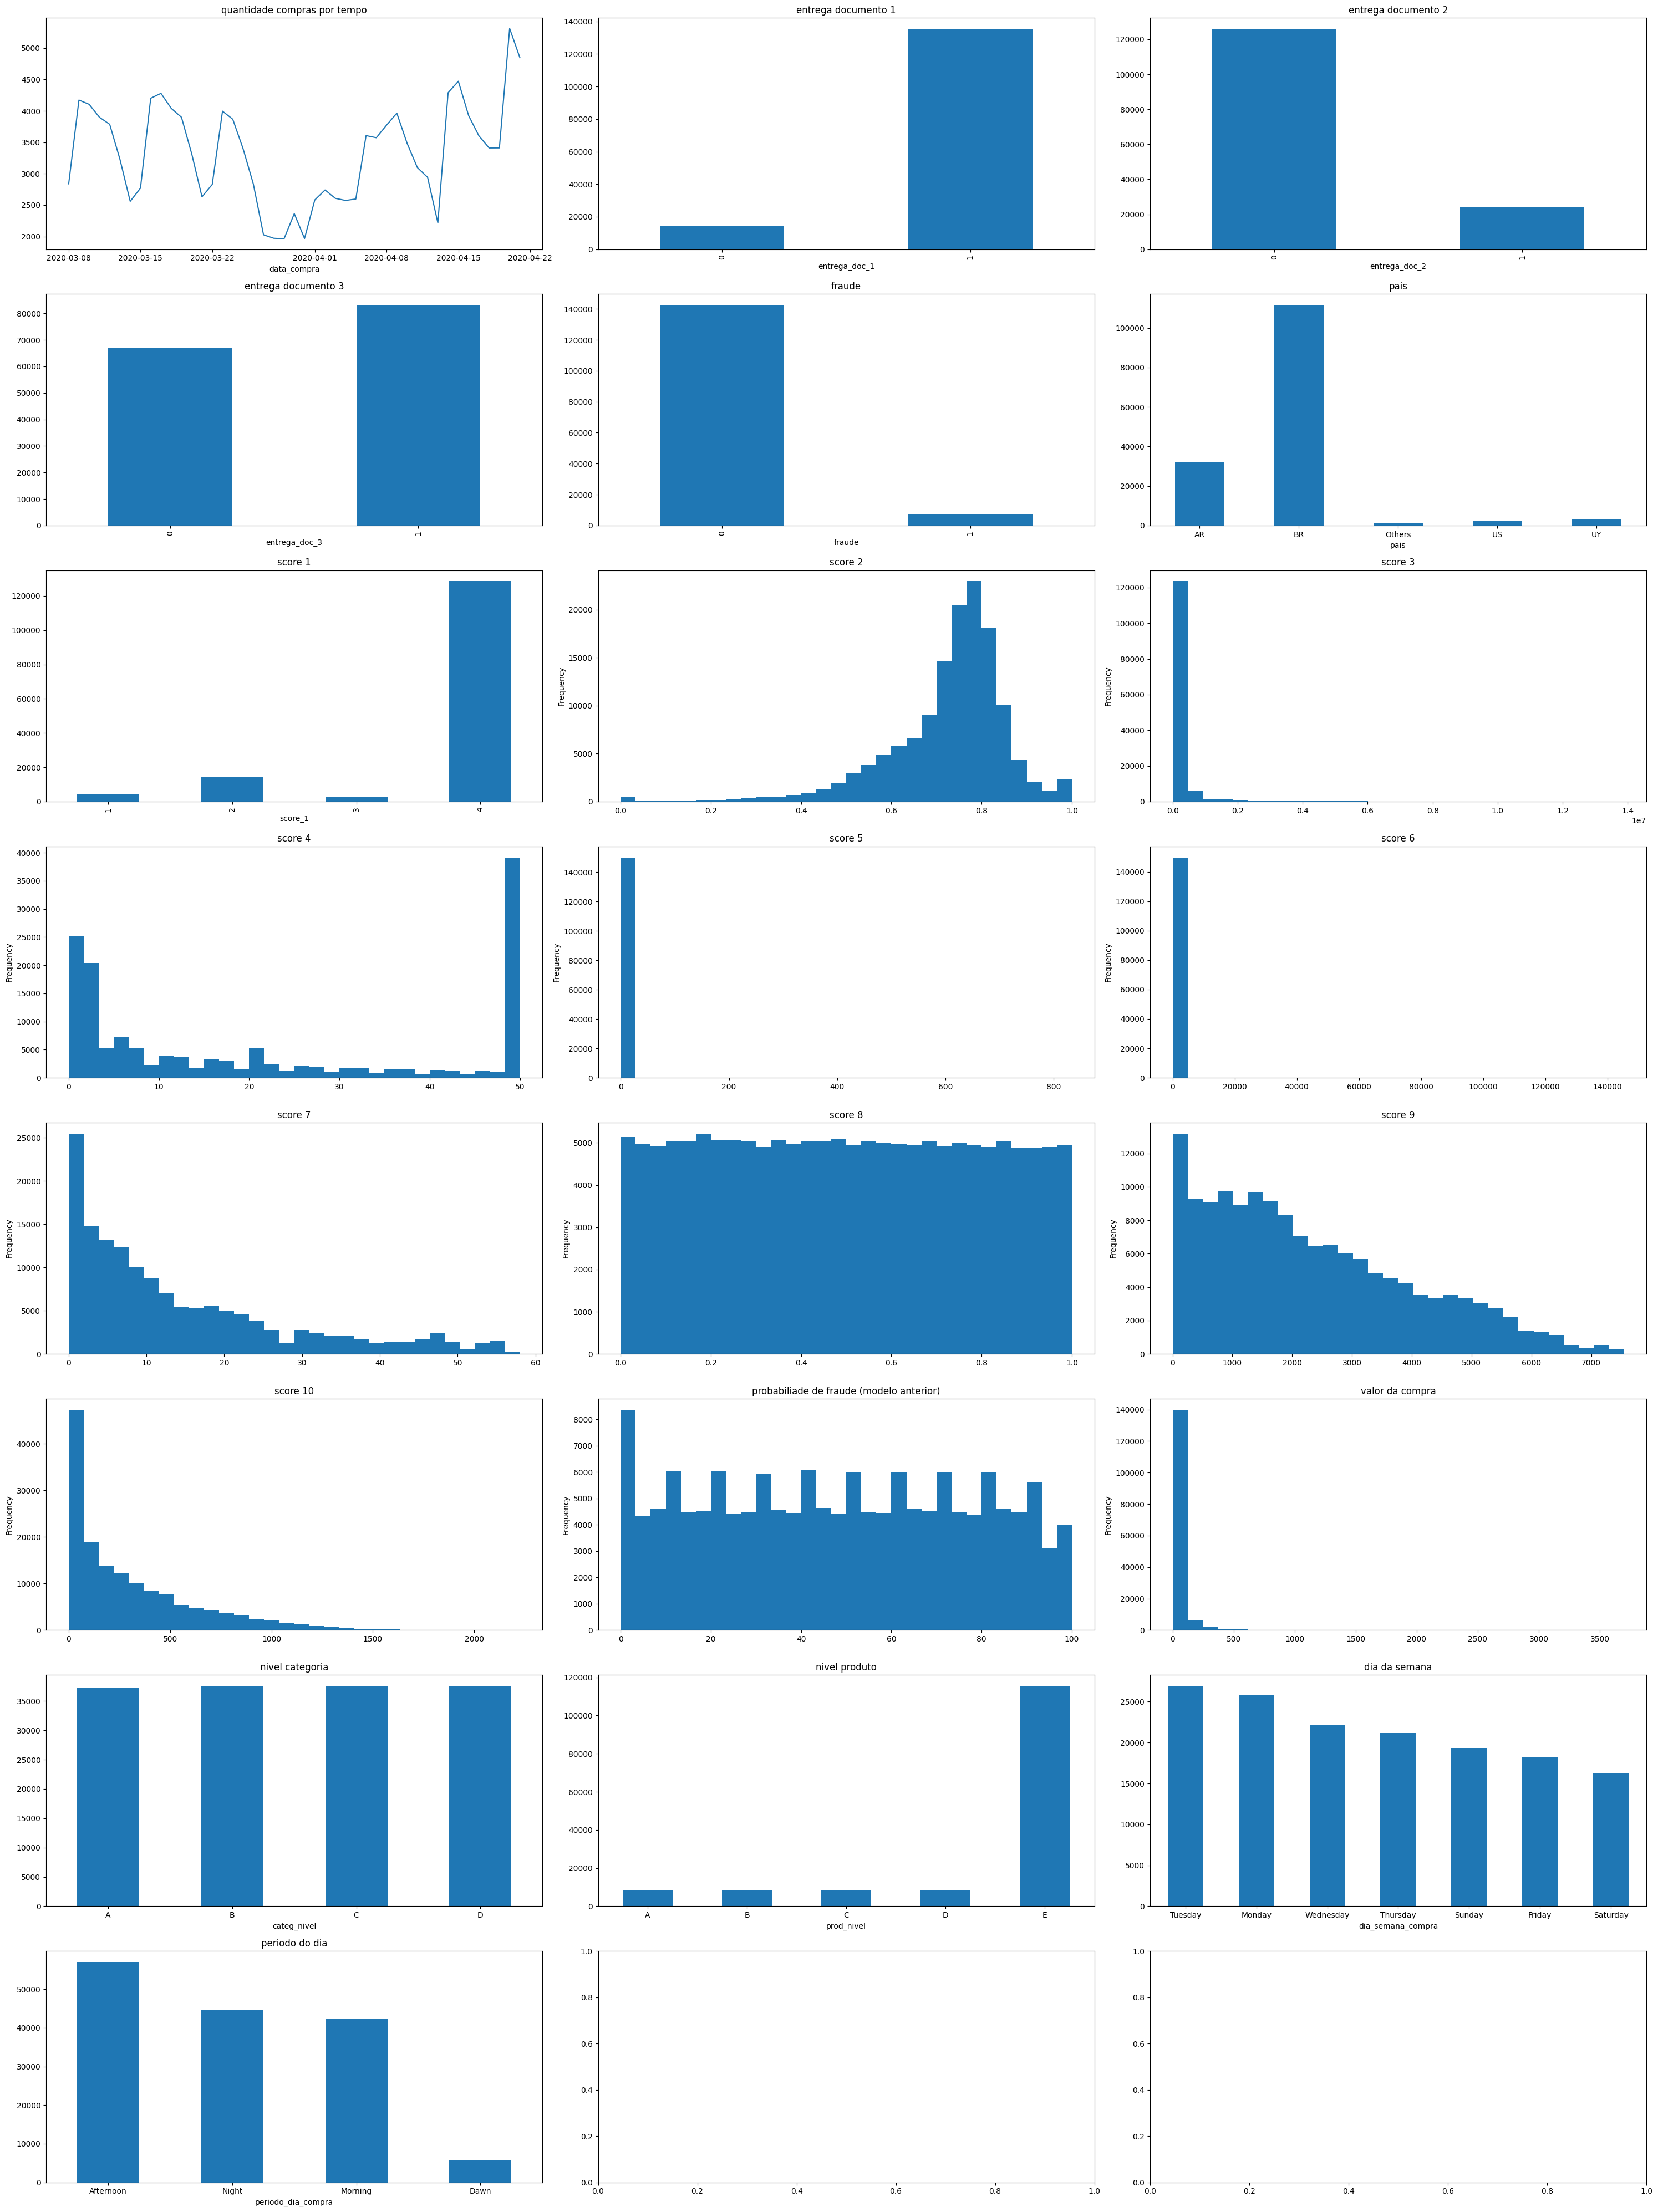

In [133]:

lines = 8
columns = 3
fig, axs = plt.subplots(lines, columns, figsize=(30, 5*lines))

df.groupby('data_compra')['valor_compra'].count().plot.line(ax=axs[0, 0])
axs[0, 0].set_title('quantidade compras por tempo')

df['entrega_doc_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('entrega documento 1')

df['entrega_doc_2'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 2])
axs[0, 2].set_title('entrega documento 2')

df['entrega_doc_3'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 0])
axs[1, 0].set_title('entrega documento 3')

df['fraude'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('fraude')

df['pais'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 2])
axs[1, 2].tick_params(axis='x', labelrotation=0)
axs[1, 2].set_title('pais')

df['score_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[2, 0])
axs[2, 0].set_title('score 1')

df['score_2'].plot.hist(bins=30, ax=axs[2, 1])
axs[2, 1].set_title('score 2')

df['score_3'].plot.hist(bins=30, ax=axs[2, 2])
axs[2, 2].set_title('score 3')

df['score_4'].plot.hist(bins=30, ax=axs[3, 0])
axs[3, 0].set_title('score 4')

df['score_5'].plot.hist(bins=30, ax=axs[3, 1])
axs[3, 1].set_title('score 5')

df['score_6'].plot.hist(bins=30, ax=axs[3, 2])
axs[3, 2].set_title('score 6')

df['score_7'].plot.hist(bins=30, ax=axs[4, 0])
axs[4, 0].set_title('score 7')

df['score_8'].plot.hist(bins=30, ax=axs[4, 1])
axs[4, 1].set_title('score 8')

df['score_9'].plot.hist(bins=30, ax=axs[4, 2])
axs[4, 2].set_title('score 9')

df['score_10'].plot.hist(bins=30, ax=axs[5, 0])
axs[5, 0].set_title('score 10')

df['score_fraude_modelo'].plot.hist(bins=30, ax=axs[5, 1])
axs[5, 1].set_title('probabiliade de fraude (modelo anterior)')

df['valor_compra'].plot.hist(bins=30, ax=axs[5, 2])
axs[5, 2].set_title('valor da compra')

df['categ_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 0])
axs[6, 0].set_title('nivel categoria')
axs[6, 0].tick_params(axis='x', labelrotation=0)

df['prod_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 1])
axs[6, 1].set_title('nivel produto')
axs[6, 1].tick_params(axis='x', labelrotation=0)

df['dia_semana_compra'].value_counts(normalize=False).plot.bar(ax=axs[6, 2])
axs[6, 2].set_title('dia da semana')
axs[6, 2].tick_params(axis='x', labelrotation=0)

df['periodo_dia_compra'].value_counts(normalize=False).plot.bar(ax=axs[7, 0])
axs[7, 0].set_title('periodo do dia')
axs[7, 0].tick_params(axis='x', labelrotation=0)

# plt.suptitle('Univariate analisys')
plt.tight_layout()
plt.show()

*insights:*
- **quantidade de compras por tempo:** apresentou tendencia nula e sazonalidade entre 08/03 até 26/03, depois disso apresentou tendencia positiva e falta de sazonalidade.
- **entrega de documentos:** (1) mais comum apresentar; (2) mais comum não apresentar; (3) apresentar ou não apresentar é balanceado.
- **fraude:** existem pouquissimas fraudes.
- **país:** existe pouco mais que 50 paises que compraram, sendo assim BR o top 1 disparado, AR como top 2.
- **scores:** cada um possui uma distribuição em particular, scores 3,5 e 6 possuem outliers "pesados".
- **modelo anterior para fraude:** bem balanceado em sua inferencia, oq pode significar que o modelo era ruim pois existem pouquissimas fraudes nos dados.
- **valor de compra:** em grande parte possui baixo valor. possui outliers "pesados".
- **nivel de categoria:** balanceado *(difinição dos niveis de categoria foram definidos em **Cleaning** and **Modeling**)*.
- **nivel de produtos:** balanceado para niveis diferente de E *(difinição dos niveis de produtos foram definidos em **Cleaning** and **Modeling**)*.
- **dia da semana:** as compras são mais provaveis de acontecerem no começo da semana (a partir de segunda-feira).
- **periodo do dia:** as compras são mais provaveis de acontecerem inicio do dia (a partir da manhã).

###### Respondido: Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc

#### **Bivariate** analisys

In [134]:
...

Ellipsis

### **KPI**s